# NRC-21 Astrometric Calibration

The purpose of this activity is to determine the plate scale, orientation, and geometric distortion for each SCA in each NIRCam module at a range of wavelengths. This will involve observing a standard astrometric field at a set of mosaicked and dithered offsets through a representative set of filters. The LMC calibration field (R.A = 05:21:57 and Dec = -69:29:51) in JWST’s CVZ has been carefully chosen and mapped with HST’s ACS to facilitate such a calibration.

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Enable inline plotting at lower left
%matplotlib inline

# Load progress bars
from tqdm.auto import trange, tqdm

In [12]:
import pysiaf

import webbpsf_ext
from webbpsf_ext import coords
from webbpsf_ext import robust
from webbpsf_ext.utils import S
from webbpsf_ext.coords import jwst_point

import pynrc
from pynrc import nrc_utils
from pynrc.simul.apt import DMS_input

from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u

pynrc.setup_logging('WARN', verbose=False)

# Read in LMC catalog

In [6]:
# Read in master source table and FITS file
cat_file = '../LMC_catalogs/lmc_catalog_flag1.cat'
names = [
    'index', 'ra', 'dec', 'F070W', 'F090W', 'F115W', 'F140M', 'F150W', 'F150W2',
    'F162M', 'F164N', 'F182M', 'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 
    'F300M','F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 
    'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

tbl = ascii.read(cat_file, names=names)

print(tbl)

index          ra        ...       F470N              F480M       
------ ----------------- ... ------------------ ------------------
     1     80.4803123692 ... 22.594089999999998           22.64905
     2 80.47963276760001 ...           21.23549            21.2941
     3 80.48015521319999 ...           21.86378           21.92011
     4     80.4797549688 ...           20.94596            21.0055
     5 80.47871544430001 ...           21.59785 21.655260000000002
     6     80.4784391387 ...           22.79301           22.84689
     7     80.4801662669 ...           22.02741           22.08435
     8     80.4813365338 ...           20.91658           20.97622
     9     80.4789181619 ...           21.15316           21.21171
    10 80.48166715810001 ...           22.71334            22.7633
   ...               ... ...                ...                ...
213343     80.4994427873 ...           21.79022 21.847720000000002
213344      80.497823658 ...           21.28024 21.33872000000

In [7]:
# Turn RA/Dec fields into Skycoords object
ra_deg, dec_deg = (tbl['ra'], tbl['dec'])
obj_coords = SkyCoord(ra_deg, dec_deg, unit=u.deg, frame='icrs')

# Create Observation Parameter Sets

In [65]:
# APT input files
json_file     = 'NRC-21.timing.json'
sm_acct_file  = 'NRC-21.smart_accounting'
pointing_file = 'NRC-21.pointing'
xml_file      = 'NRC-21.xml'

# Create DMS Input class
obs_input = DMS_input(xml_file, pointing_file, json_file, sm_acct_file)

# Update observing start date/time and V3 PA
obs_input.obs_date = '2022-03-01'
obs_input.obs_time = '12:00:00'
obs_input.pa_v3 = 0

# Generate all observation parameters for every visit, exposure, detector, etc
obs_params_all = obs_input.gen_all_obs_params()

  0%|          | 0/488 [00:00<?, ?it/s]

## Plot stars in focal plane

We want to use pysiaf to grab the telescope (V2/V3) coordinates of the NIRCam detectors as projected on the sky. We will then transform all of the RA/Dec info into V2/V3 coords for our catalog of stars assuming the telescope is pointed at a specific RA/Dec and oriented with a certain position angle.

In [66]:
hdul = fits.open('../LMC_catalogs/LMC Calibration Field 2020/LMC_JWSTCAL_2017.fits')
hdu = hdul[0]

# Set up a WCS for for the image
wcs = WCS(hdu.header)

hdul.close()

In [67]:
obs_params = obs_params_all[4]

In [68]:
# Reference aperture (NRCALL_FULL) for telescope pointing
ap_ref_name = obs_params['siaf_ap_ref'].AperName
# Observed aperture (NRCA5_FULL) for detector
ap_obs_name = obs_params['siaf_ap'].AperName
# Reference RA/Dec of aperture prior to offseting/dithering
ra_ref, dec_ref = (obs_params['ra'], obs_params['dec']) 
pos_ang = obs_params['pa_v3']

# Pointing offsets
visit_label = obs_params['visit_key']
visit_dict = obs_input.program_info[visit_label]
base_offset  = (visit_dict['basex'][0], visit_dict['basey'][0])
dith_offsets = list(zip(visit_dict['dithx'], visit_dict['dithy']))

# Set pointing uncertainties to 0mas
base_std = dith_std = 0

tel_pointing = jwst_point(ap_obs_name, ap_ref_name, ra_ref, dec_ref, pos_ang=pos_ang, 
                          base_offset=base_offset, dith_offsets=dith_offsets, 
                          base_std=base_std, dith_std=dith_std)

# Standard SAM (not SGD)
tel_pointing.use_sgd = False

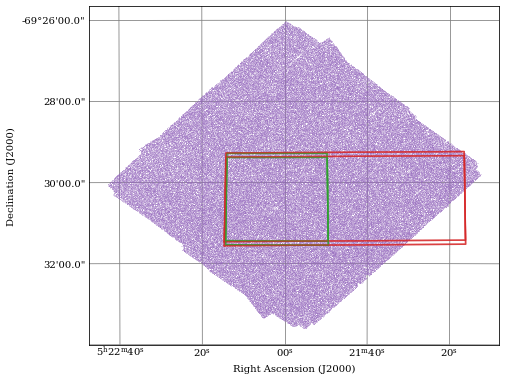

In [85]:
fig, ax = plt.subplots(1,1, figsize=(6,5.5))

ax = plt.subplot(projection=wcs)
ax.plot_coord(obj_coords, ls='none', marker=',', alpha=0.25, color='C4')

ax.coords.grid(color='gray', linestyle='solid')
lon = ax.coords[0]
lat = ax.coords[1]

lon.set_axislabel('Right Ascension (J2000)')
lat.set_axislabel('Declination (J2000)')
lon.set_major_formatter('hh:mm:ss')
lat.set_major_formatter('dd:mm:ss.s')
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)

# Convert aperture V2/V3 vertices to RA/Dec
for idl_off in tel_pointing.position_offsets_act:
    ra_ap, dec_ap = tel_pointing.ap_radec(idl_off=idl_off, get_cenpos=False, get_vert=True, 
                                          ap_siaf_obs=tel_pointing.siaf_ap_ref)
    ap_coord = SkyCoord(ra_ap, dec_ap, unit='deg', frame='icrs')
    ax.plot_coord(ap_coord, color='C0', alpha=0.5)

for idl_off in tel_pointing.position_offsets_act:
    ra_ap, dec_ap = tel_pointing.ap_radec(idl_off=idl_off, get_cenpos=False, get_vert=True)
    ap_coord = SkyCoord(ra_ap, dec_ap, unit='deg', frame='icrs')
    ax.plot_coord(ap_coord, color='C1', alpha=0.5)
    
fig.tight_layout()

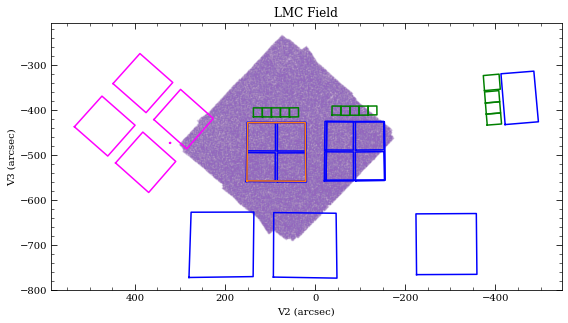

In [98]:
# Convert RA, Dec coordiantes into V2/V3 (arcsec)
ra_deg  = obj_coords.ra.deg
dec_deg = obj_coords.dec.deg
idl_off = [tel_pointing.position_offsets_act[0]]
v2_obj, v3_obj = tel_pointing.radec_to_frame((ra_deg, dec_deg), frame_out='tel', idl_offsets=idl_off)

# Plot aperture files
fig, ax = plt.subplots(1,1)

# V2/V3 positions of all objects
ax.scatter(v2_obj, v3_obj, s=1, marker='.', alpha=0.1, color='C4')

# Plot all the telescope aperture (NIRCam, NIRSpec, NIRIS, MIRI, and FGS)
tel_pointing.plot_main_apertures(ax=ax)

# Plot the 
tel_pointing.plot_obs_aperture(ax=ax, color='C1')

ax.set_title('LMC Field')
fig.tight_layout()

# Simulate Field

In [11]:
def mag_to_counts(src_mag, bandpass, sp_type='flat'):
    """
    Convert stellar magnitudes in some bandpass to flux values (e-/sec)
    """
    
    from pynrc import stellar_spectrum
    
    # Get flux of a 0 magnitude star (zero-point flux)
    sp = stellar_spectrum(sp_type, 0, 'vegamag', bandpass)
    obs = S.Observation(sp, bandpass, binset=bandpass.wave)
    zp_counts = obs.effstim('counts') # Counts of a 0 mag star
    
    # Flux of each star e-/sec
    src_flux = np.array(zp_counts * 10**(-src_mag / 2.5))
    
    return src_flux

In [12]:
nrc = pynrc.NIRCam(filter='F444W', apname=ap_obs_name)
nrc.gen_wfefield_coeff()
nrc.gen_wfedrift_coeff()

In [13]:
siaf_ap_obs = tel_pointing.siaf_ap_obs

# Get all source fluxes
mags = tbl[nrc.filter].data
flux_obj = mag_to_counts(mags, nrc.bandpass)

# And their corresponding science pixel locations
xsci_obj, ysci_obj = siaf_ap_obs.convert(v2_obj, v3_obj, 'tel', 'sci')

In [14]:
osamp = 1

xsci, ysci, im_pom = nrc_utils.pickoff_image(ap_obs_name, v2_obj, v3_obj, flux_obj, 
                                             oversample=osamp)

# Crop based on subarray window size
# Maximum required size depends on PSF and detector readout size

# Create temporary PSF
psf_temp = nrc.calc_psf_from_coeff(return_oversample=True, return_hdul=False)
psf_temp = nrc_utils.frebin(psf_temp, scale=osamp/nrc.oversample)
ny_psf, nx_psf = psf_temp.shape

xmin, ymin = int(-nx_psf/2), int(-ny_psf/2)
xmax = int(siaf_ap_obs.XSciSize + nx_psf/2)
ymax = int(siaf_ap_obs.YSciSize + ny_psf/2)

xmask = (xsci>=xmin) & (xsci<xmax)
ymask = (ysci>=ymin) & (ysci<ymax)

# Keep only regions that contribute to final convolved image
xsci = xsci[xmask]
ysci = ysci[ymask]
im_pom = im_pom[ymask][:,xmask]

In [15]:
# Create science image
hdul_sci_image = fits.HDUList([fits.PrimaryHDU(im_pom)])
hdul_sci_image[0].header['PIXELSCL'] = nrc.pixelscale / osamp
hdul_sci_image[0].header['OSAMP'] = osamp
hdul_sci_image[0].header['INSTRUME'] = nrc.name
hdul_sci_image[0].header['APERNAME'] = ap_obs_name
# Get X and Y indices corresponding to center of aperture
hdul_sci_image[0].header['XCEN'] = np.argmin(np.abs(xsci - siaf_ap_obs.XSciRef))
hdul_sci_image[0].header['YCEN'] = np.argmin(np.abs(ysci - siaf_ap_obs.YSciRef))
hdul_sci_image[0].header['CFRAME'] = 'sci'

In [16]:
print(xsci.shape, ysci.shape, im_pom.shape, ny_psf, nx_psf)

(2304,) (2304,) (2304, 2304) 257 257


In [17]:
xpsf = int(len(xsci) / (150 * osamp))
ypsf = int(len(ysci) / (150 * osamp))

if xpsf<5:
    xpsf = 5
if ypsf<5:
    ypsf = 5
    
# Create a grid of PSFs across the field of view
xsci_vals = np.linspace(xsci.min(),xsci.max(),xpsf)
ysci_vals = np.linspace(ysci.min(),ysci.max(),ypsf)
xsci_psf, ysci_psf = np.meshgrid(xsci_vals, ysci_vals)

# These sci coordinates are for siaf_ap_obs aperture
# which might be different than the PSF coordiantes.
# Convert everything to tel to be consistent.
xsci_psf = xsci_psf.flatten()
ysci_psf = ysci_psf.flatten()

xtel_psf, ytel_psf = siaf_ap_obs.convert(xsci_psf, ysci_psf, 'sci', 'tel')

hdul_psfs = nrc.calc_psf_from_coeff(coord_vals=(xtel_psf, ytel_psf), coord_frame='tel', 
                                    return_oversample=True)

if osamp != hdul_psfs[0].header['OSAMP']:
    for hdu in hdul_psfs:
        hdu.data = nrc_utils.frebin(hdu.data, scale=osamp/hdu.header['OSAMP'])
        hdu.header['PIXELSCL'] = hdu.header['PIXELSCL'] * hdu.header['OSAMP'] / osamp
        hdu.header['OSAMP'] = osamp

PSFs:   0%|          | 0/225 [00:00<?, ?it/s]

In [18]:
from webbpsf_ext.image_manip import convolve_image
im_conv = convolve_image(hdul_sci_image, hdul_psfs)

  0%|          | 0/225 [00:00<?, ?it/s]

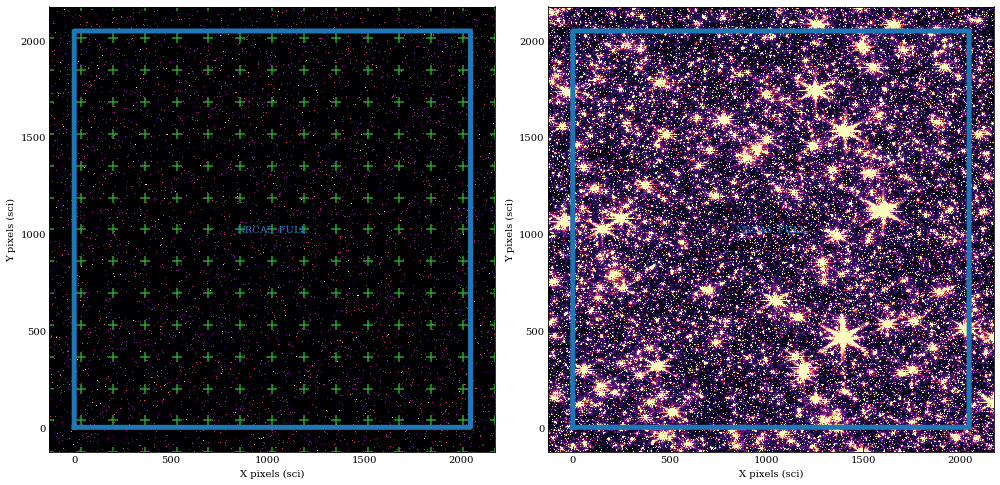

In [19]:
fig, axes = plt.subplots(1,2, figsize=(14,7))

extent = [xsci.min(), xsci.max(), ysci.min(), ysci.max()]

for i, im in enumerate([im_pom**0.2, im_conv]):
    ax = axes[i]

    ind = im!=0
    med = np.median(im[ind])
    std = robust.medabsdev(im[ind])
    vmin, vmax = med + 5*std*np.array([-1,1])
    ax.imshow(im, extent=extent, vmin=0, vmax=vmax, cmap='magma')

    tel_pointing.plot_obs_aperture(frame='sci', ax=ax, label=True, color='C0', lw=5)

    if i==0:
        ax.scatter(xsci_psf.flatten(), ysci_psf.flatten(), marker='+', color='C2', s=100)

#     ax.set_xlim([0,100])
#     ax.set_ylim([0,100])
        
fig.tight_layout()

V2/V3 Offset: (3.727, -5.412)


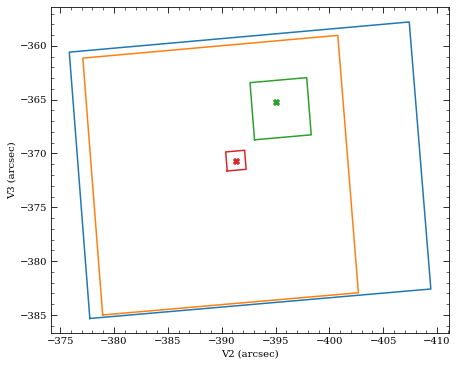

In [112]:
import pysiaf
miri_siaf = pysiaf.Siaf('MIRI')

siaf_1a = miri_siaf['MIRIM_TA1550_UR']
siaf_1b = miri_siaf['MIRIM_TA1550_CUR']

# Random 'sci' coordinate centroid of a star
xci_1a, ysci_1a = np.random.uniform(10,35, size=2)
# Convert to V2/V3 coords
v2_1a, v3_1a = siaf_1a.convert(xci_1a, ysci_1a, 'sci', 'tel')

# Get reference point for 1b in V2/V3 coords
v2ref_1b, v3ref_1b = siaf_1b.reference_point('tel')

# Determine required telescope pointing offset in V2/V3 plane
# Is the sign correct??
v2_offset = v2ref_1b - v2_1a
v3_offset = v3ref_1b - v3_1a

print(f'V2/V3 Offset: ({v2_offset:.3f}, {v3_offset:.3f})')

# Plot everything
fig, ax = plt.subplots(1,1)
siafs_1550C = [
    'MIRIM_MASK1550', 'MIRIM_CORON1550',
    'MIRIM_TA1550_UR', 'MIRIM_TA1550_CUR'
]
for ap in siafs_1550C:
    ap_siaf = miri_siaf[ap]
    ap_siaf.plot(ax=ax)
    
ax.scatter(v2_1a, v3_1a, marker='X', color='C2')
ax.scatter(v2ref_1b, v3ref_1b, marker='X', color='C3')

In [120]:
import pysiaf
from webbpsf_ext.coords import radec_offset, xy_to_rtheta

miri_siaf = pysiaf.Siaf('MIRI')

siaf_1550 = miri_siaf['MIRIM_MASK1550']
siaf_1a   = miri_siaf['MIRIM_TA1550_UR']
siaf_1b   = miri_siaf['MIRIM_TA1550_CUR']

# Get reference points for each aperture in in V2/V3 coords
tel_ref_0  = np.array(siaf_1550.reference_point('tel'))
tel_ref_1a = np.array(siaf_1a.reference_point('tel'))
tel_ref_1b = np.array(siaf_1b.reference_point('tel'))

# Calculate offsets of 1a and 1b apertures
offsets_1a = tel_ref_1a - tel_ref_0
offsets_1b = tel_ref_1b - tel_ref_0

# Convert to (r, theta)
r_1a, th_1a = xy_to_rtheta(offsets_1a[0], offsets_1a[1])
r_1b, th_1b = xy_to_rtheta(offsets_1b[0], offsets_1b[1])

# Assume center of mask at RA, Dec = (0,0) 
ra0, dec0 = (0,0)

# Get RA/Dec offsets for 1a and 1b ref points
ra_1a, dec_1a = radec_offset(ra0, dec0, r_1a, th_1a)
ra_1b, dec_1b = radec_offset(ra0, dec0, r_1b, th_1b)

print(ra_1a, dec_1a)
print(ra_1b, dec_1b)

# point_info = jwst_point()

0.0015498705560265033 0.0017606808331186014
0.0003968041666503372 0.00042167861110773384


In [123]:
import pysiaf

miri_siaf = pysiaf.Siaf('MIRI')

siaf_1550 = miri_siaf['MIRIM_MASK1550']
siaf_1a   = miri_siaf['MIRIM_TA1550_UR']
siaf_1b   = miri_siaf['MIRIM_TA1550_CUR']

# Get reference points for each aperture in in V2/V3 coords
tel_ref_0  = siaf_1550.reference_point('tel')
tel_ref_1a = siaf_1a.reference_point('tel')
tel_ref_1b = siaf_1b.reference_point('tel')

# Assume center of mask at RA, Dec = (0,0) 
ra_ref, dec_ref = (0,0)
pa_ref = 0

# Attitude correction matrix relative to reference aperture
# Set an attitude matrix, for use in subsequent transforms to sky frame.
att = pysiaf.utils.rotations.attitude(tel_ref_0[0], tel_ref_0[1], ra_ref, dec_ref, pa_ref)
siaf_1550.set_attitude_matrix(att)

# Convert from V2/V3 to absolute RA/Dec
ra_1a, dec_1a = siaf_1550.tel_to_sky(*tel_ref_1a)
ra_1b, dec_1b = siaf_1550.tel_to_sky(*tel_ref_1b)

print(ra_1a, dec_1a)
print(ra_1b, dec_1b)


359.99845013188155 0.001760680795509483
359.999603196474 0.0004216786086318206


In [127]:
from astropy import units as u
from astropy.coordinates import SkyCoord

# Get base coordinates in astropy SkyCoord class
c0 = SkyCoord(ra_ref*u.deg, dec_ref*u.deg, frame='icrs')
c1a = SkyCoord(ra_1a*u.deg, dec_1a*u.deg, frame='icrs')
c1b = SkyCoord(ra_1b*u.deg, dec_1b*u.deg, frame='icrs')

dra_1a, ddec_1a = c0.spherical_offsets_to(c1a)
dra_1b, ddec_1b = c0.spherical_offsets_to(c1b)

print(dra_1a.to('arcsec'), ddec_1a.to('arcsec'))
print(dra_1b.to('arcsec'), ddec_1b.to('arcsec'))

-5.57953arcsec 6.33845arcsec
-1.42849arcsec 1.51804arcsec


In [125]:
c0.spherical_offsets_to(c1a)

(<Angle -0.00154987 deg>, <Angle 0.00176068 deg>)

In [117]:
att = pysiaf.utils.rotations.attitude(v2_ref, v3_ref, ra_ref, dec_ref, pa_ref)
siaf_1550._attitude_matrix